## 온도 예측문제 데이터 불러오기
- 379 페이지

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-08-30 04:02:13--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.177.205, 54.231.235.0, 52.216.133.157, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.177.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  41.5MB/s    in 0.3s    

2023-08-30 04:02:14 (41.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


### 예나 날씨 데이터셋 확인

In [2]:
import os # 경로 관련 라이브러리
fname = os.path.join('jena_climate_2009_2016.csv')
with open(fname) as f:
  data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


### 데이터 파싱

In [3]:
import numpy as np
temperature = np.zeros((len(lines), )) # 1차원 배열
temperature.shape
raw_data = np.zeros((len(lines), len(header) - 1))
raw_data.shape

(420451, 14)

In [4]:
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]] # 하나의 행
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

In [5]:
temperature[0], raw_data[0]

(-8.02,
 array([ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02]))

### 시각화

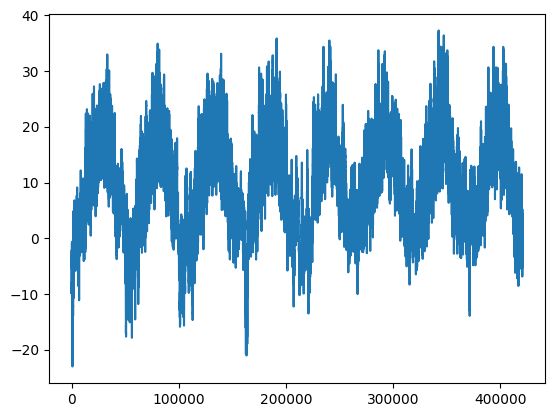

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.plot(range(len(temperature)), temperature)
plt.show()

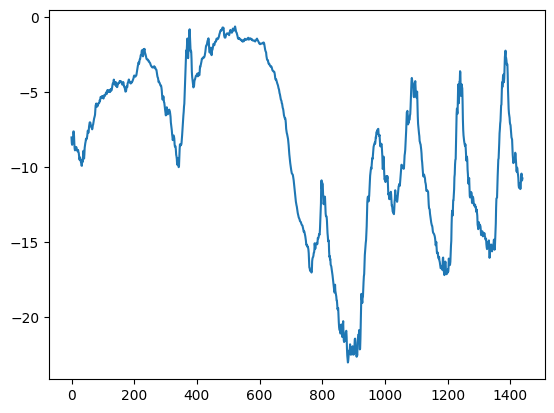

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(range(1440), temperature[:1440])
plt.show()

- 교재 해석(382 페이지) : 이 그래프에서 일별 주기성을 볼 수 있다. 마지막 4일간 데이터를 보면 확실하다
- 10일의 기간은 아주 추운 겨울에 해당 (2009년, 1월 1일)
- 예측 알고리즘
  + 선택 1 : 통계 방법
  + 선택 2 : 머신러닝
  + 선택 3 : 딥러닝

## 데이터 준비

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


- 383 페이지

In [10]:
# Data Leakage
# 훈련 데이터와 테스트 데이터 정보가 섞이면 안됨
# 테스트 데이터의 정보를 모름 >> 어떻게 평균을 구하냐? 못구함.
# 정규화는 해야해서 훈련 데이터 정보를 테스트 데이터에 적용

mean = raw_data[:num_train_samples].mean(axis = 0) # 훈련데이터의 평균 가져옴
raw_data -= mean

std = raw_data[:num_train_samples].std(axis = 0) # 훈련데이터의 표준편차 가져옴
raw_data /= std

## timeseries_dataset_from_array
- tensorflow가 원하는 방식으로 데이터셋을 정렬
- raw_data와 temperature 배열만 메모리에 유지하고 샘플수정

In [13]:
import numpy as np
from tensorflow import keras

int_sequence = np.arange(10)
print(int_sequence[:-3])
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data = int_sequence[:-3],
    targets  = int_sequence[3:],
    sequence_length = 3,
    batch_size = 2
)

# type(dummy_dataset)
for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))

[0 1 2 3 4 5 6]
[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


### 훈련, 검증, 테스트 데이터셋 만들기
- 시간당 하나의 데이터가 샘플링된다



In [14]:
sampling_rate = 6 # 10분 단위로 데이터가 들어감 = 1시간에 6번 입력
sequence_length = 120 # 이전 120시간 데이터를 사용함
delay = sampling_rate * (sequence_length + 24 - 1) # 24시간 후 온도를 수치적으로 표현
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

## 훈련 데이터셋의 배치 크기 확인

In [15]:
for samples, targets in train_dataset:
  print('샘플 크기:', samples.shape)
  print('타겟 크기:', targets.shape)
  break

샘플 크기: (256, 120, 14)
타겟 크기: (256,)


## 평가지표 만들기
- MAE 평가지표를 만들자

In [16]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 10.28
테스트 MAE: 10.40


## 기본 연결 모델
- 밀집 연결 모델

In [17]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 48s 52ms/step - loss: 12.0331 - mae: 2.6908 - val_loss: 10.5132 - val_mae: 2.5427
Epoch 2/10
819/819 [==============================] - 51s 62ms/step - loss: 8.7452 - mae: 2.3295 - val_loss: 10.7210 - val_mae: 2.5742
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 8.0344 - mae: 2.2350 - val_loss: 10.1627 - val_mae: 2.5070
Epoch 4/10
819/819 [==============================] - 51s 62ms/step - loss: 7.6056 - mae: 2.1774 - val_loss: 11.6439 - val_mae: 2.6980
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 7.2979 - mae: 2.1312 - val_loss: 11.3486 - val_mae: 2.6697
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 7.0674 - mae: 2.0975 - val_loss: 12.7969 - val_mae: 2.8136
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 6.9029 - mae: 2.0733 - val_loss: 11.8832 - val_mae: 2.7015
Epoch 8/10
819/819 [==============================] - 

- 1D 합성곱 모델

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 65s 71ms/step - loss: 24.7017 - mae: 3.8234 - val_loss: 15.1777 - val_mae: 3.0777
Epoch 2/10
819/819 [==============================] - 49s 59ms/step - loss: 15.7864 - mae: 3.1591 - val_loss: 14.6393 - val_mae: 3.0225
Epoch 3/10
819/819 [==============================] - 60s 72ms/step - loss: 14.7576 - mae: 3.0547 - val_loss: 16.6717 - val_mae: 3.2285
Epoch 4/10
819/819 [==============================] - 64s 78ms/step - loss: 14.1066 - mae: 2.9854 - val_loss: 16.5249 - val_mae: 3.2070
Epoch 5/10
819/819 [==============================] - 53s 64ms/step - loss: 13.6306 - mae: 2.9279 - val_loss: 17.2009 - val_mae: 3.2728
Epoch 6/10
819/819 [==============================] - 51s 62ms/step - loss: 13.1806 - mae: 2.8737 - val_loss: 22.6956 - val_mae: 3.7935
Epoch 7/10
819/819 [==============================] - 54s 66ms/step - loss: 12.7948 - mae: 2.8286 - val_loss: 16.3800 - val_mae: 3.1606
Epoch 8/10
819/819 [============================

- 392 페이지
  + 이 데이터는 순서가 많이 중요함
  + 어제 데이터가 5일전 데이터보다 내일 온도를 예측하는데 훨씬 유용!
  
    =>> CNN 모델은 이런 사실을 활용할 수 없고, MaxPooling, AveragePooling 순서 정보가 많이 삭제됨

### LSTM

In [22]:
sequence_length, raw_data.shape[-1]

(120, 14)

In [23]:
inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1])) # input
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1984      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [24]:
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstml.keras', save_base_only = True)
]

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics = ['mae'])
history = model.fit(
    train_dataset,
    epochs = 10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 50s 58ms/step - loss: 42.1773 - mae: 4.7301 - val_loss: 13.2816 - val_mae: 2.7955
Epoch 2/10
819/819 [==============================] - 52s 63ms/step - loss: 11.2415 - mae: 2.6084 - val_loss: 9.9762 - val_mae: 2.4651
Epoch 3/10
819/819 [==============================] - 52s 63ms/step - loss: 9.8612 - mae: 2.4570 - val_loss: 9.7184 - val_mae: 2.4268
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 9.4457 - mae: 2.4013 - val_loss: 9.9703 - val_mae: 2.4387
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 9.2193 - mae: 2.3681 - val_loss: 10.2276 - val_mae: 2.4731
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 8.9870 - mae: 2.3382 - val_loss: 10.0148 - val_mae: 2.4439
Epoch 7/10
819/819 [==============================] - 52s 63ms/step - loss: 8.8076 - mae: 2.3135 - val_loss: 9.7354 - val_mae: 2.4070
Epoch 8/10
819/819 [==============================] - 47s

In [30]:
import matplotlib.pyplot as plt
def check_train_val_plot(history):
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

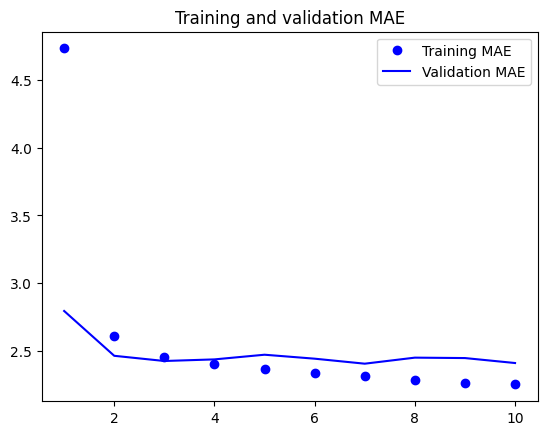

In [31]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [26]:
model = keras.models.load_model('jena_lstml.keras')
print(model.evaluate(test_dataset)[1])

405/405 [==============================] - 16s 38ms/step - loss: 11.3067 - mae: 2.6057
2.605677843093872


## numpy로 구현한 RNN

In [37]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features, ))
state_t.shape

# 가중치 행렬
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features))

successive_outputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_outputs.append(output_t)
  state_t = output_t # RNN 코드의 핵심

final_output_sequence = np.stack(successive_outputs, axis = 0)
final_output_sequence

array([[1.        , 0.99999999, 0.99999999, ..., 0.99999997, 0.99999973,
        0.99999954],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])